## Analysis of biophysicial properties at boundaries

- Find boundaries between cell type compartments
- Compute heterotypic and homotypic tension statistics
- Generate plots of gene expression and tension as a function of distance from boundary

### Imports and data input

Select dataset - can be one of `dataset1`, `dataset2`, `dataset3`

In [1]:
dataset = 'dataset3'

Module imports

In [2]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from skimage import io
import pandas as pd
import seaborn as sns
import scipy.stats
from tqdm import tqdm
from helper_functions import *
import os

#### Data import

In [3]:
# Gene expression matrix, cell adjacency matrix, force imputation results
gex_res = pd.read_csv(f'../reproduce_data/{dataset}/gex_res.csv', index_col=0)
adj_mat = pd.read_csv(f'../reproduce_data/{dataset}/adj_mat.csv', index_col=0)
tensionmap_data = pd.read_csv(f'../reproduce_data/{dataset}/tensionmap_res.csv', index_col=0)

# Segmented image and cell positions for spatial plots

img_path = skimage.io.imread(f'../reproduce_data/{dataset}/segmentation_final.tif')
cell_positions = tensionmap_data[['centroid_x', 'centroid_y']]/2

### Find boundaries between cell type compartments

In [4]:
boundary_celltypes = np.unique(tensionmap_data['boundary_annotation'].values)
boundary_celltypes = boundary_celltypes[boundary_celltypes != 'Other']

Find boundary between cell types

In [5]:
# Find metric to highlight boundary between two celltypes or clusters
# Use frac(homotypic) * frac(heterotypic)
# value is high when cell has 1/2 neighbours of its own type and 1/2 neighbours of other cell type

boundary_likelihood = np.zeros(tensionmap_data.shape[0])

for i, cell in enumerate(tensionmap_data.index.values):
    n = np.where(adj_mat.loc[cell,:] != 0)[0]
    neigh_celltypes = tensionmap_data['boundary_annotation'].iloc[n,].values
    if len(neigh_celltypes) == 0:
        continue
    frac_1 = np.divide(np.sum(np.isin(neigh_celltypes,boundary_celltypes[0])), len(neigh_celltypes))
    frac_2 = np.divide(np.sum(np.isin(neigh_celltypes,boundary_celltypes[1])), len(neigh_celltypes))
    boundary_likelihood[i] = frac_1*frac_2
    boundary_likelihood[boundary_likelihood < 0.15] = 0

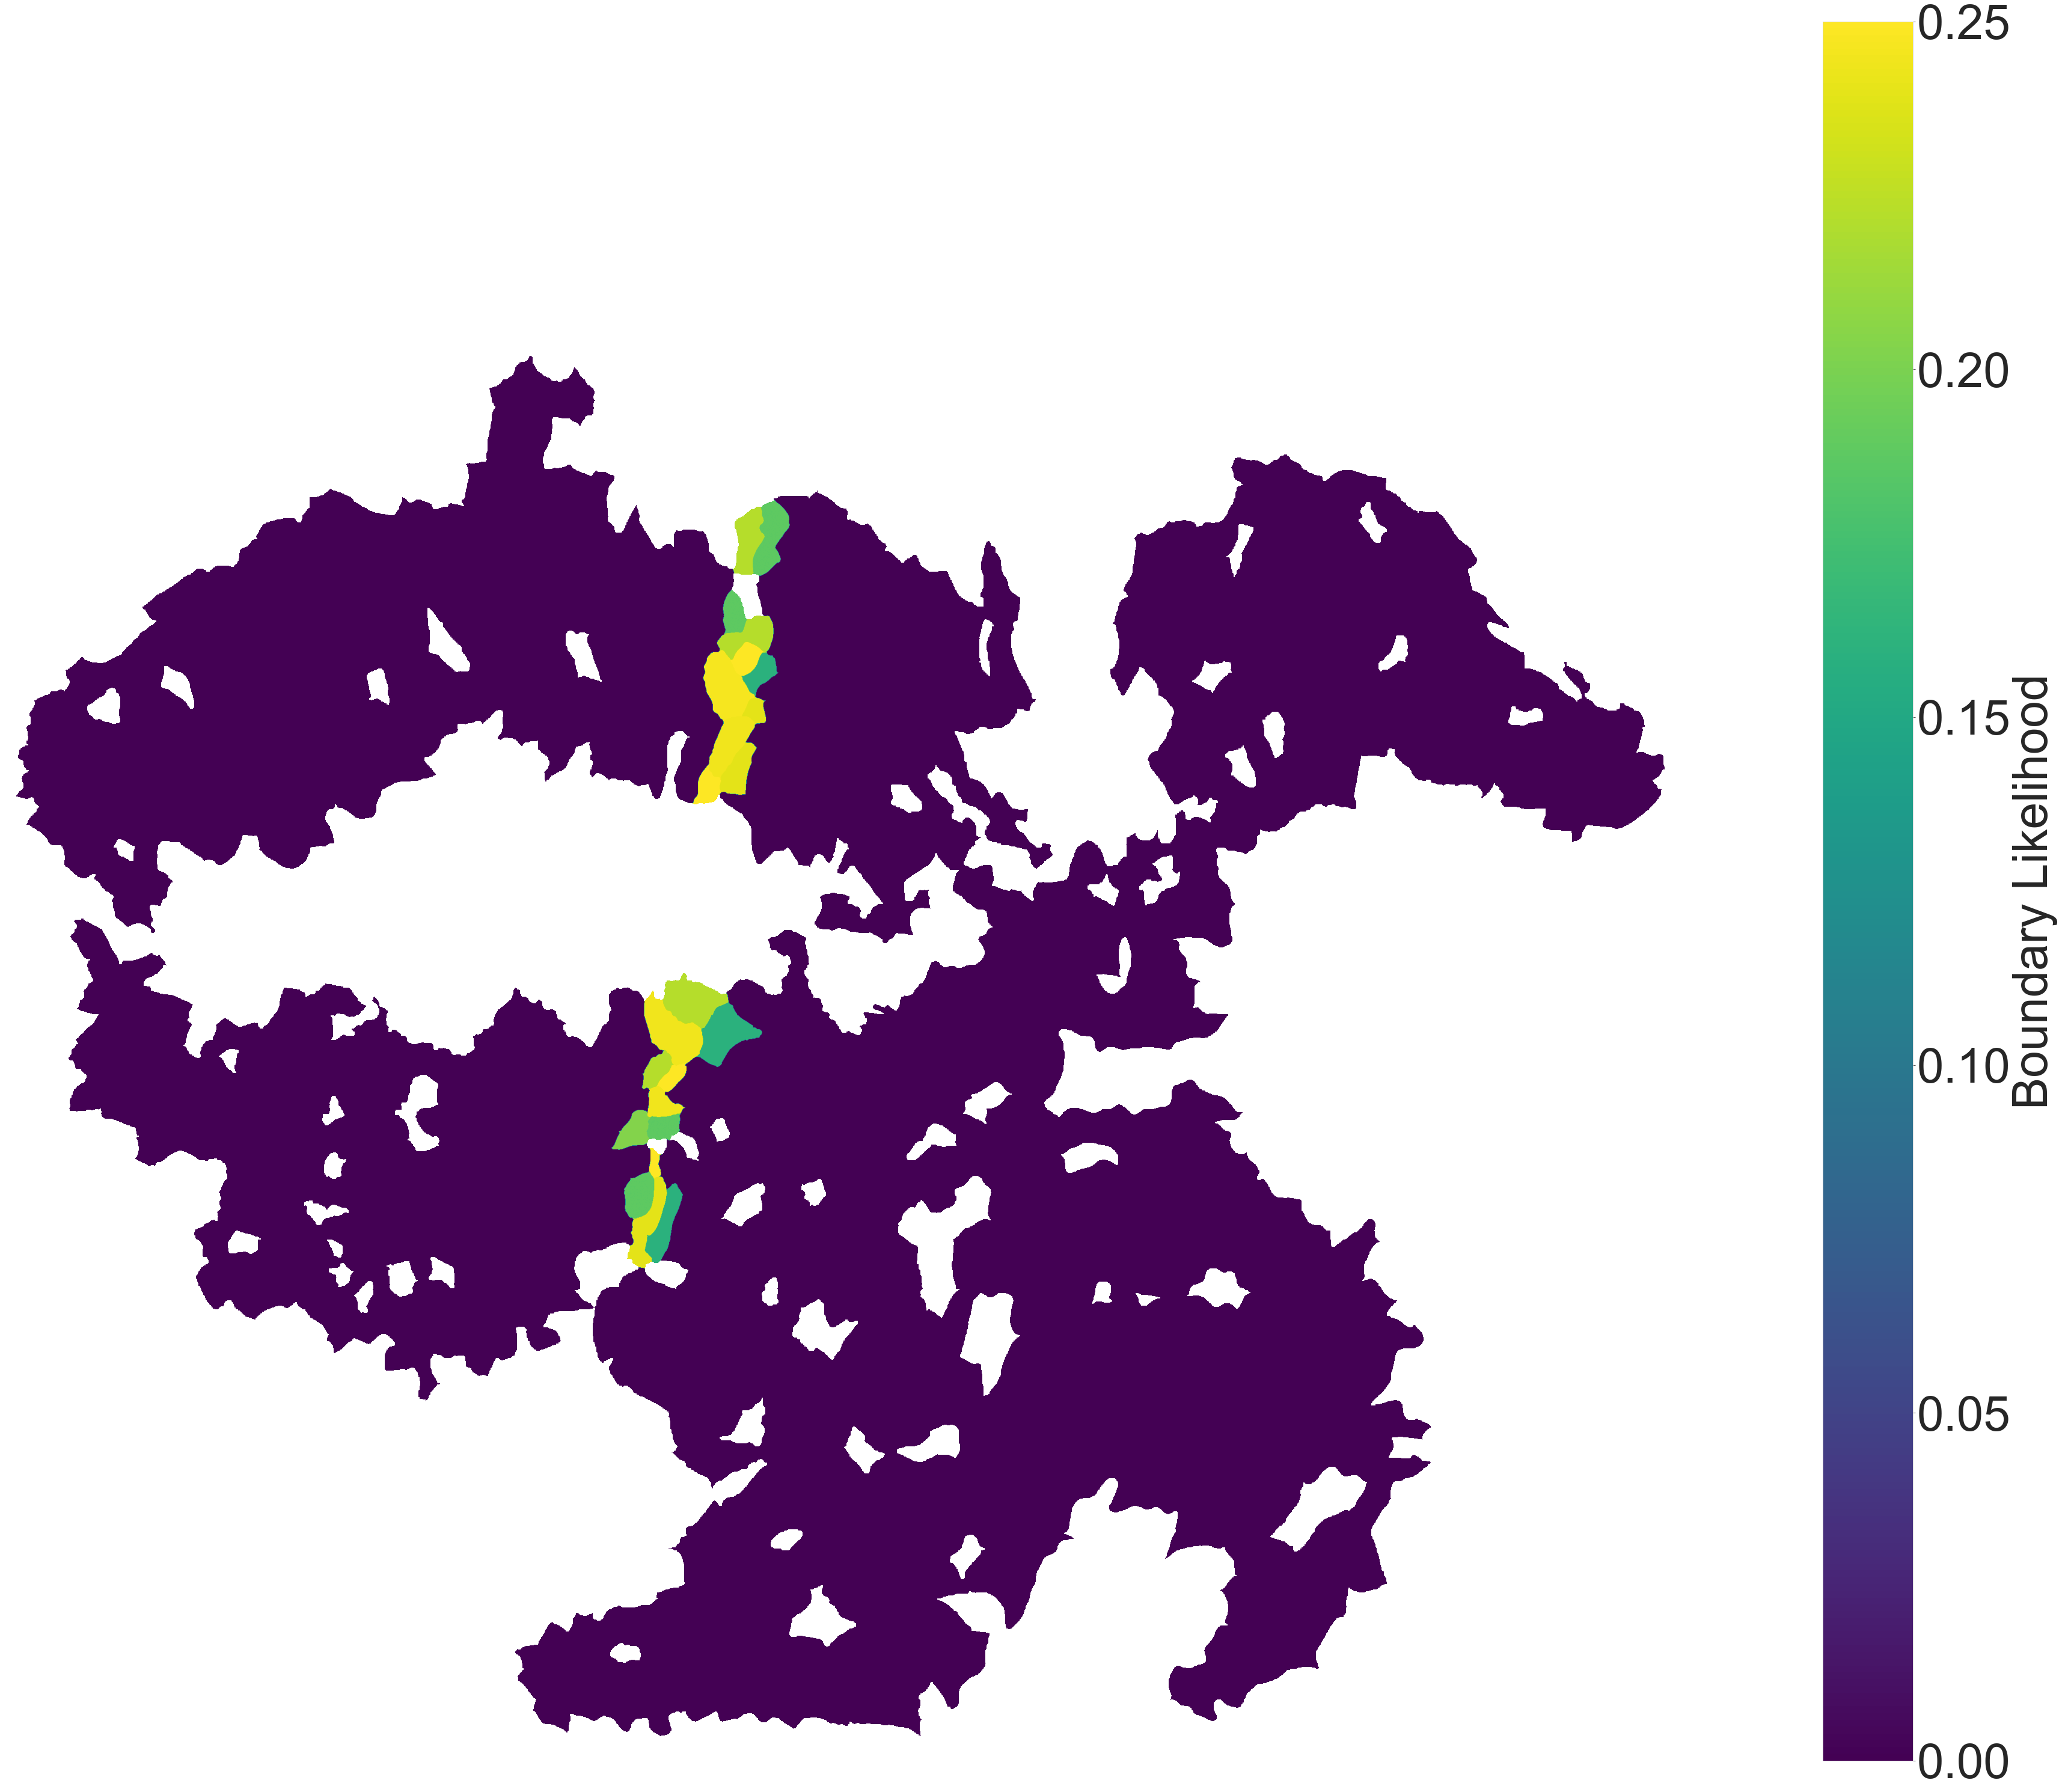

In [6]:
# Plot on spatial plot
spatialplot(boundary_likelihood, 'continuous', cell_positions, img_path, legend='Boundary Likelihood', size=80, norm=False)

Compute distance to boundary for all cells

In [7]:
# Compute distance from boundary
# Uses # of neighbours as distance instead of pixel distance

distance_to_boundary = -1 * np.ones(adj_mat.shape[0])

distance_to_boundary[boundary_likelihood > 0] = 0

n_neighbours = 1
while any(distance_to_boundary == -1) and n_neighbours > 0:
    curr_cells = np.where(distance_to_boundary != -1)[0]
    neighbours = np.where(np.sum(adj_mat.iloc[curr_cells,:].values, axis=0) != 0)[0]
    neighbours = neighbours[np.isin(neighbours, curr_cells, invert=True)]

    n_neighbours = len(neighbours)
    distance_to_boundary[neighbours] = np.max(distance_to_boundary) + 1

distance_to_boundary = pd.DataFrame(data=distance_to_boundary, columns=['distance'])
distance_to_boundary.set_index(adj_mat.index, inplace=True)

Compute heterotypic and homotypic junction tensions.
Junctions are classified as one of three types:

- heterotypic at boundary
- homotypic at boundary
- homotypic away from boundary

We are interested in heterotypic at-boundary junctions and homotypic away-from-boundary junctions

In [8]:
boundary_adj_mat = adj_mat.iloc[np.isin(tensionmap_data['boundary_annotation'], boundary_celltypes),np.isin(tensionmap_data['boundary_annotation'], boundary_celltypes)]
edge_indices = np.nonzero(np.triu(boundary_adj_mat))
boundary_tensions = pd.DataFrame(data=np.array([boundary_adj_mat.columns.values[edge_indices[0]], boundary_adj_mat.columns.values[edge_indices[1]],
                                                boundary_adj_mat.to_numpy()[edge_indices[0], edge_indices[1]]]).T,
                                 columns=['cell_1', 'cell_2', 'tension'])

boundary_tensions['type'] = ''
boundary_tensions['distance_to_boundary'] = 0
boundary_tensions['tension'] = boundary_tensions['tension'].astype(float)

for boundary in boundary_tensions.index:
    celltype_1 = tensionmap_data.loc[boundary_tensions.loc[boundary, 'cell_1'], 'boundary_annotation']
    celltype_2 = tensionmap_data.loc[boundary_tensions.loc[boundary, 'cell_2'], 'boundary_annotation']

    dist_1 = distance_to_boundary.loc[boundary_tensions.loc[boundary, 'cell_1']].values
    dist_2 = distance_to_boundary.loc[boundary_tensions.loc[boundary, 'cell_2']].values
    distance = np.min([dist_1, dist_2])
    boundary_tensions.loc[boundary, 'distance_to_boundary'] = distance

    if np.isin(celltype_1,boundary_celltypes[0]) and np.isin(celltype_2,boundary_celltypes[1]) and distance == 0:
        boundary_tensions.loc[boundary, 'type'] = 'heterotypic'
    elif np.isin(celltype_2,boundary_celltypes[0]) and np.isin(celltype_1,boundary_celltypes[1]) and distance == 0:
        boundary_tensions.loc[boundary, 'type'] = 'heterotypic'
    elif np.isin(celltype_1,boundary_celltypes[0]) and np.isin(celltype_2,boundary_celltypes[0]) and distance == 0:
        boundary_tensions.loc[boundary, 'type'] = f'{boundary_celltypes[0]}_at_boundary'
    elif np.isin(celltype_1,boundary_celltypes[0]) and np.isin(celltype_2,boundary_celltypes[0]) and 1 <= distance <= 5:
        boundary_tensions.loc[boundary, 'type'] = f'{boundary_celltypes[0]}_awayfrom_boundary'
    elif np.isin(celltype_1,boundary_celltypes[1]) and np.isin(celltype_2,boundary_celltypes[1]) and distance == 0:
        boundary_tensions.loc[boundary, 'type'] =  f'{boundary_celltypes[1]}_at_boundary'
    elif np.isin(celltype_1,boundary_celltypes[1]) and np.isin(celltype_2,boundary_celltypes[1]) and 1 <= distance <= 5:
        boundary_tensions.loc[boundary, 'type'] =  f'{boundary_celltypes[1]}_awayfrom_boundary'
    else:
        boundary_tensions.loc[boundary, 'type'] = 'other'

Summarise across boundary types and generate bar plot

In [9]:
boundary_tensions = boundary_tensions.loc[np.isin(boundary_tensions['type'], ['heterotypic',f'{boundary_celltypes[0]}_awayfrom_boundary',f'{boundary_celltypes[1]}_awayfrom_boundary']),]
boundary_summary = boundary_tensions.groupby('type')['tension'].agg(['mean','sem','median'])
boundary_summary = boundary_summary[boundary_summary.index.values!='other']

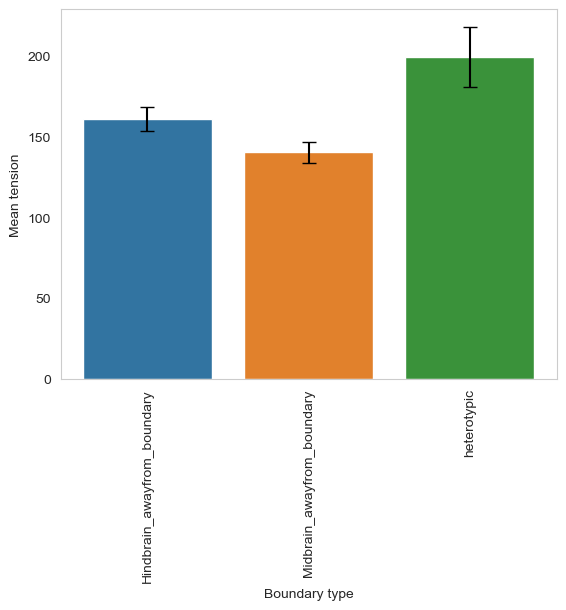

In [10]:
ax = sns.barplot(x=boundary_summary.index, y="mean", data=boundary_summary,
                 order=[f'{boundary_celltypes[0]}_awayfrom_boundary',f'{boundary_celltypes[1]}_awayfrom_boundary','heterotypic'])

plt.xticks(rotation=90)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
ax.errorbar(x=x_coords, y=y_coords, yerr=boundary_summary["sem"], fmt="none", c="k", capsize=5)
ax.grid(False)
plt.xlabel('Boundary type')
plt.ylabel('Mean tension')
plt.show()

Make summary table

In [11]:
boundary_stats = pd.DataFrame(np.zeros([len(np.unique(boundary_tensions['type'].values)), 4]), columns=['mean','median','sem','n_obs'], index=np.unique(boundary_tensions['type'].values))

for boundary_type in boundary_stats.index:
    boundary_stats.loc[boundary_type, 'median'] = np.median(boundary_tensions.iloc[boundary_tensions['type'].values == boundary_type,]['tension'].values)
    boundary_stats.loc[boundary_type, 'mean'] = np.mean(boundary_tensions.iloc[boundary_tensions['type'].values == boundary_type,]['tension'].values)
    boundary_stats.loc[boundary_type, 'sem'] = scipy.stats.sem(boundary_tensions.iloc[boundary_tensions['type'].values == boundary_type,]['tension'].values)
    boundary_stats.loc[boundary_type, 'n_obs'] = boundary_tensions.iloc[boundary_tensions['type'].values == boundary_type,]['tension'].values.shape[0]

boundary_stats = boundary_stats.loc[boundary_stats.index.values != 'other',:]

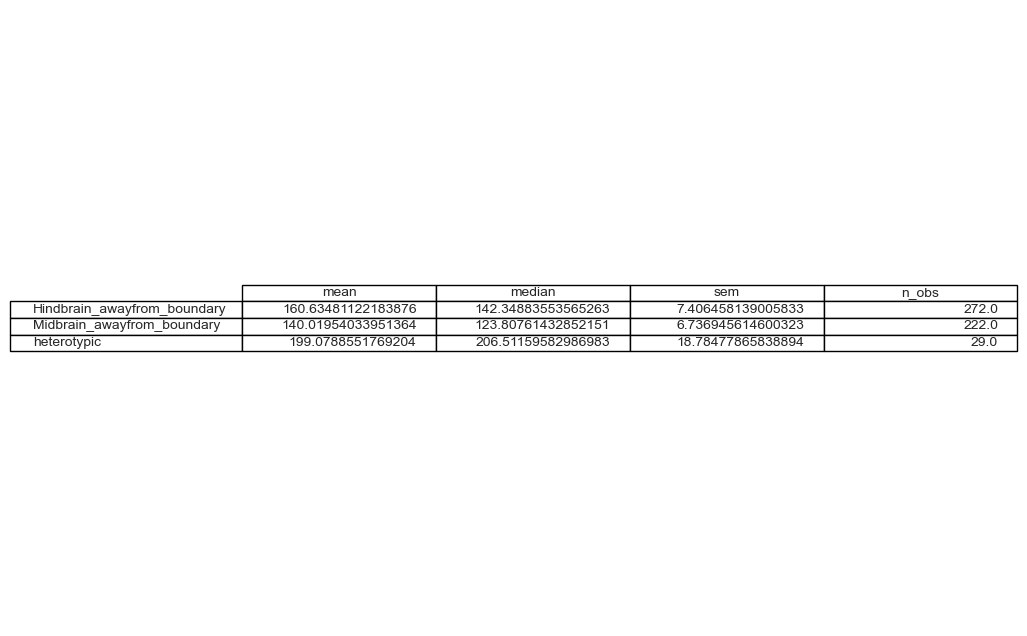

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.table(cellText=boundary_stats.values, colLabels=boundary_stats.keys(), rowLabels=boundary_stats.index.values,
         loc='center', fontsize=100)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.axis('off')
plt.show()

### Generate plots of gene expression and tension at boundaries

Plot of mean tension as a function of distance from boundary

/Users/rhe/Desktop/Projects/PartIII/TensionMap/notebooks/helper_functions.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


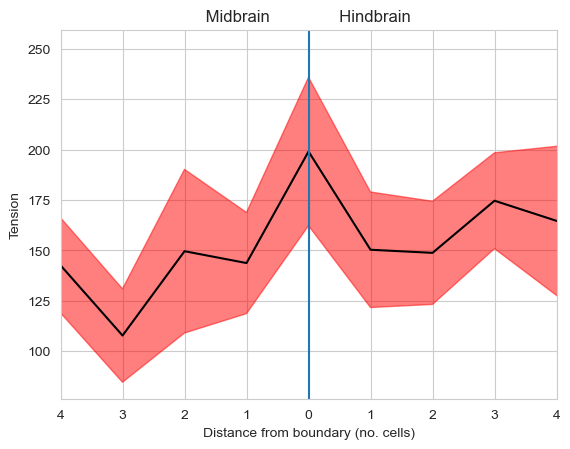

In [13]:
p = tension_lineplot(boundary_tensions, boundary_celltypes, xlim=[-4, 4])
p

Plot tension and marker gene expression as a function of distance from boundary

Example marker genes:

- Data set 1: *Snai1*, *Otx2*
- Data set 2: *Bmp4*, *Wnt5b*
- Data set 3: *Gbx2*, *Otx2*

In [14]:
boundary_markers = ['Gbx2','Otx2']

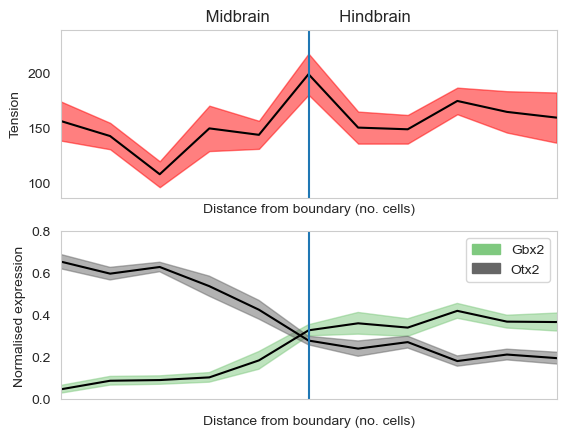

In [15]:
p = tension_gex_lineplot(boundary_tensions, boundary_celltypes, boundary_markers, gex_res, tensionmap_data, distance_to_boundary, xlim= [-5,5], fill_type='sem')
p

Plot gene expression as a function of distance from boundary

Example genes with interesting expression patterns at boundaries:

- Data set 1: *Cdh2*, *Cdh20*, *Wnt5a*, *Snai2*
- Data set 2: *Epha5*, *Wnt5a*, *Fzd5*, *Ephb2*
- Data set 3: *Neurog1*, *Lmo1*, *Ezr*, *Fgf8*

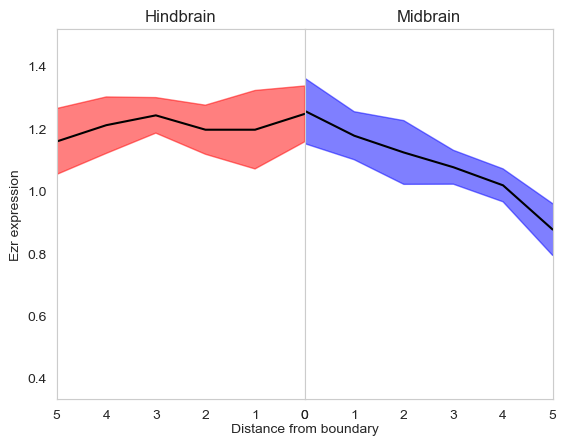

In [16]:
gex_lineplot('Ezr', tensionmap_data, boundary_celltypes, distance_to_boundary, gex_res, [5,0], [0,5])

### Save objects for further analysis

This is required for further analysis in later notebooks, please create a directory `./temp_data` if this is not present already

In [17]:
if not os.path.exists('./temp_data/'):
    os.makedirs('./temp_data/')

distance_to_boundary.to_csv('./temp_data/distance_to_boundary.csv')
boundary_tensions.to_csv('./temp_data/boundary_tensions.csv')